In [ ]:
import numpy as np
import h5py
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

### check difference

In [ ]:
data = np.array([  [0,          0.35648,        0.01215,     0.37905],
                    [np.nan,    0,              0.36516,     0.12326],
                    [np.nan,    np.nan,         0,           0.37037],
                    [np.nan,    np.nan,         np.nan,      0]]       )
data *= 100
fig, ax = plt.subplots(figsize=(3.5,3.5), dpi=300)
im = ax.imshow(data, cmap='Wistia', interpolation='nearest')

for (i, j), val in np.ndenumerate(data):
    if not np.isnan(val): 
        ax.text(j, i, f"{val:.1f}\\%", ha='center', va='center', color='black', fontsize=12) 
    
xticks = range(data.shape[1])
ax.set_xticks([x + 0.2 for x in xticks])
ax.set_yticks(range(data.shape[0]))
ax.set_xticklabels(["clean-noFS", "clean-FS", "raw-noFS", "raw-FS"], rotation=45, ha='right', fontsize = 12)
ax.set_yticklabels(["clean-noFS", "clean-FS", "raw-noFS", "raw-FS"], fontsize = 12)
ax.tick_params(axis='both', length=0)


# ax.set_title("The ratio of significantly different learning curves between the two versions of our LCDB 1.1 dataset. ")

plt.tight_layout()
plt.show()


In [ ]:
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_clean.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5']
dataset_1, dataset_2 = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]

In [ ]:
diff_matrix = np.full((24, 72), np.nan)

for data_idx in range(72):
    for learner_idx in range(24):
        lc_clean = dataset_1[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)
        lc_real = dataset_2[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)

        mask_indices = np.any((~np.isnan(lc_clean)) & (~np.isnan(lc_real)), axis=0)
        num_anchor = np.count_nonzero(mask_indices)
        lc_clean = lc_clean[:, mask_indices]
        lc_real = lc_real[:, mask_indices]

        if num_anchor == 0: 
            diff_matrix[learner_idx, data_idx] = 1

        else:
            corrected_p_value_list = []
            for anchor_idx in range(num_anchor):
                if (lc_clean[:, anchor_idx] == lc_real[:, anchor_idx]).all():
                    corrected_p_value = 1
                else: 
                    t_stat, p_value = ttest_ind(lc_clean[:, anchor_idx], lc_real[:, anchor_idx])
                    corrected_p_value = p_value * num_anchor    # Bonferroni correction
                
                corrected_p_value_list.append(corrected_p_value)
            if any(p < 0.05 for p in corrected_p_value_list):
                diff_matrix[learner_idx, data_idx] = 0
            else: 
                diff_matrix[learner_idx, data_idx] = 1

print(np.sum(diff_matrix == 0) / diff_matrix.size)

In [ ]:
plt.figure(figsize=(12, 4), dpi = 400)
ax = sns.heatmap(diff_matrix, cmap="viridis", annot=False, cbar=True, vmin=0, vmax=1)
# y tick align
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])
ax.set_yticklabels(learner_zoo, rotation=0)

# plt.title('Difference between mean learning curves (noFS) of real and clean')
plt.xlabel('Dataset Indices')
plt.show()

### performance comparision

In [2]:
file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_standardFS_raw.hdf5']
# file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_265_noFS_raw_compress.hdf5',
#                 Path.cwd() / '../dataset/LCDB11_ER_265_minmaxFS_raw_compress.hdf5',
#                 Path.cwd() / '../dataset/LCDB11_ER_265_standardFS_raw_compress.hdf5']
dataset_nofs, dataset_minmaxfs, dataset_standardfs = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]
mean_valid_nofs = np.nanmean(dataset_nofs[:,:,:,:,:,1], axis=(2,3))
mean_valid_minmaxfs = np.nanmean(dataset_minmaxfs[:,:,:,:,:,1], axis=(2,3))
mean_valid_standardfs = np.nanmean(dataset_standardfs[:,:,:,:,:,1], axis=(2,3))

file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_CC18_noFS_raw_mixNB.hdf5',
                Path.cwd() / '../dataset/LCDB11_ER_CC18_minmaxFS_raw_mixNB.hdf5']
# file_paths = [  Path.cwd() / '../dataset/LCDB11_ER_265_noFS_raw_mixNB_compress.hdf5',
#                 Path.cwd() / '../dataset/LCDB11_ER_265_minmaxFS_raw_mixNB_compress.hdf5']
dataset_nofs_mixNB, dataset_minmaxfs_mixNB = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]
mean_valid_nofs_mixNB = np.nanmean(dataset_nofs_mixNB[:,:,:,:,:,1], axis=(2,3))
mean_valid_minmaxfs_mixNB = np.nanmean(dataset_minmaxfs_mixNB[:,:,:,:,:,1], axis=(2,3))

C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\4267523947.py:8: RuntimeWarning: Mean of empty slice
  mean_valid_nofs = np.nanmean(dataset_nofs[:,:,:,:,:,1], axis=(2,3))
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\4267523947.py:9: RuntimeWarning: Mean of empty slice
  mean_valid_minmaxfs = np.nanmean(dataset_minmaxfs[:,:,:,:,:,1], axis=(2,3))
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\4267523947.py:10: RuntimeWarning: Mean of empty slice
  mean_valid_standardfs = np.nanmean(dataset_standardfs[:,:,:,:,:,1], axis=(2,3))
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\4267523947.py:17: RuntimeWarning: Mean of empty slice
  mean_valid_nofs_mixNB = np.nanmean(dataset_nofs_mixNB[:,:,:,:,:,1], axis=(2,3))
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\4267523947.py:18: RuntimeWarning: Mean of empty slice
  mean_valid_minmaxfs_mixNB = np.nanmean(dataset_minmaxfs_mixNB[:,:,:,:,:,1], axis=(2,3))


### plot NB and mixNB

C:\Users\cyan1\AppData\Local\Temp\ipykernel_5348\2748204303.py:13: RuntimeWarning: Mean of empty slice
  mean_clean_NB = np.nanmean(lc_clean_NB[data_id, LEARNER, :, :, :], axis=(0, 1))
C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cyan1\AppData\Local\Temp\ipykernel_5348\2748204303.py:15: RuntimeWarning: Mean of empty slice
  mean_clean_mixNB = np.nanmean(lc_clean_mixNB[data_id, LEARNER, :, :, :], axis=(0, 1))


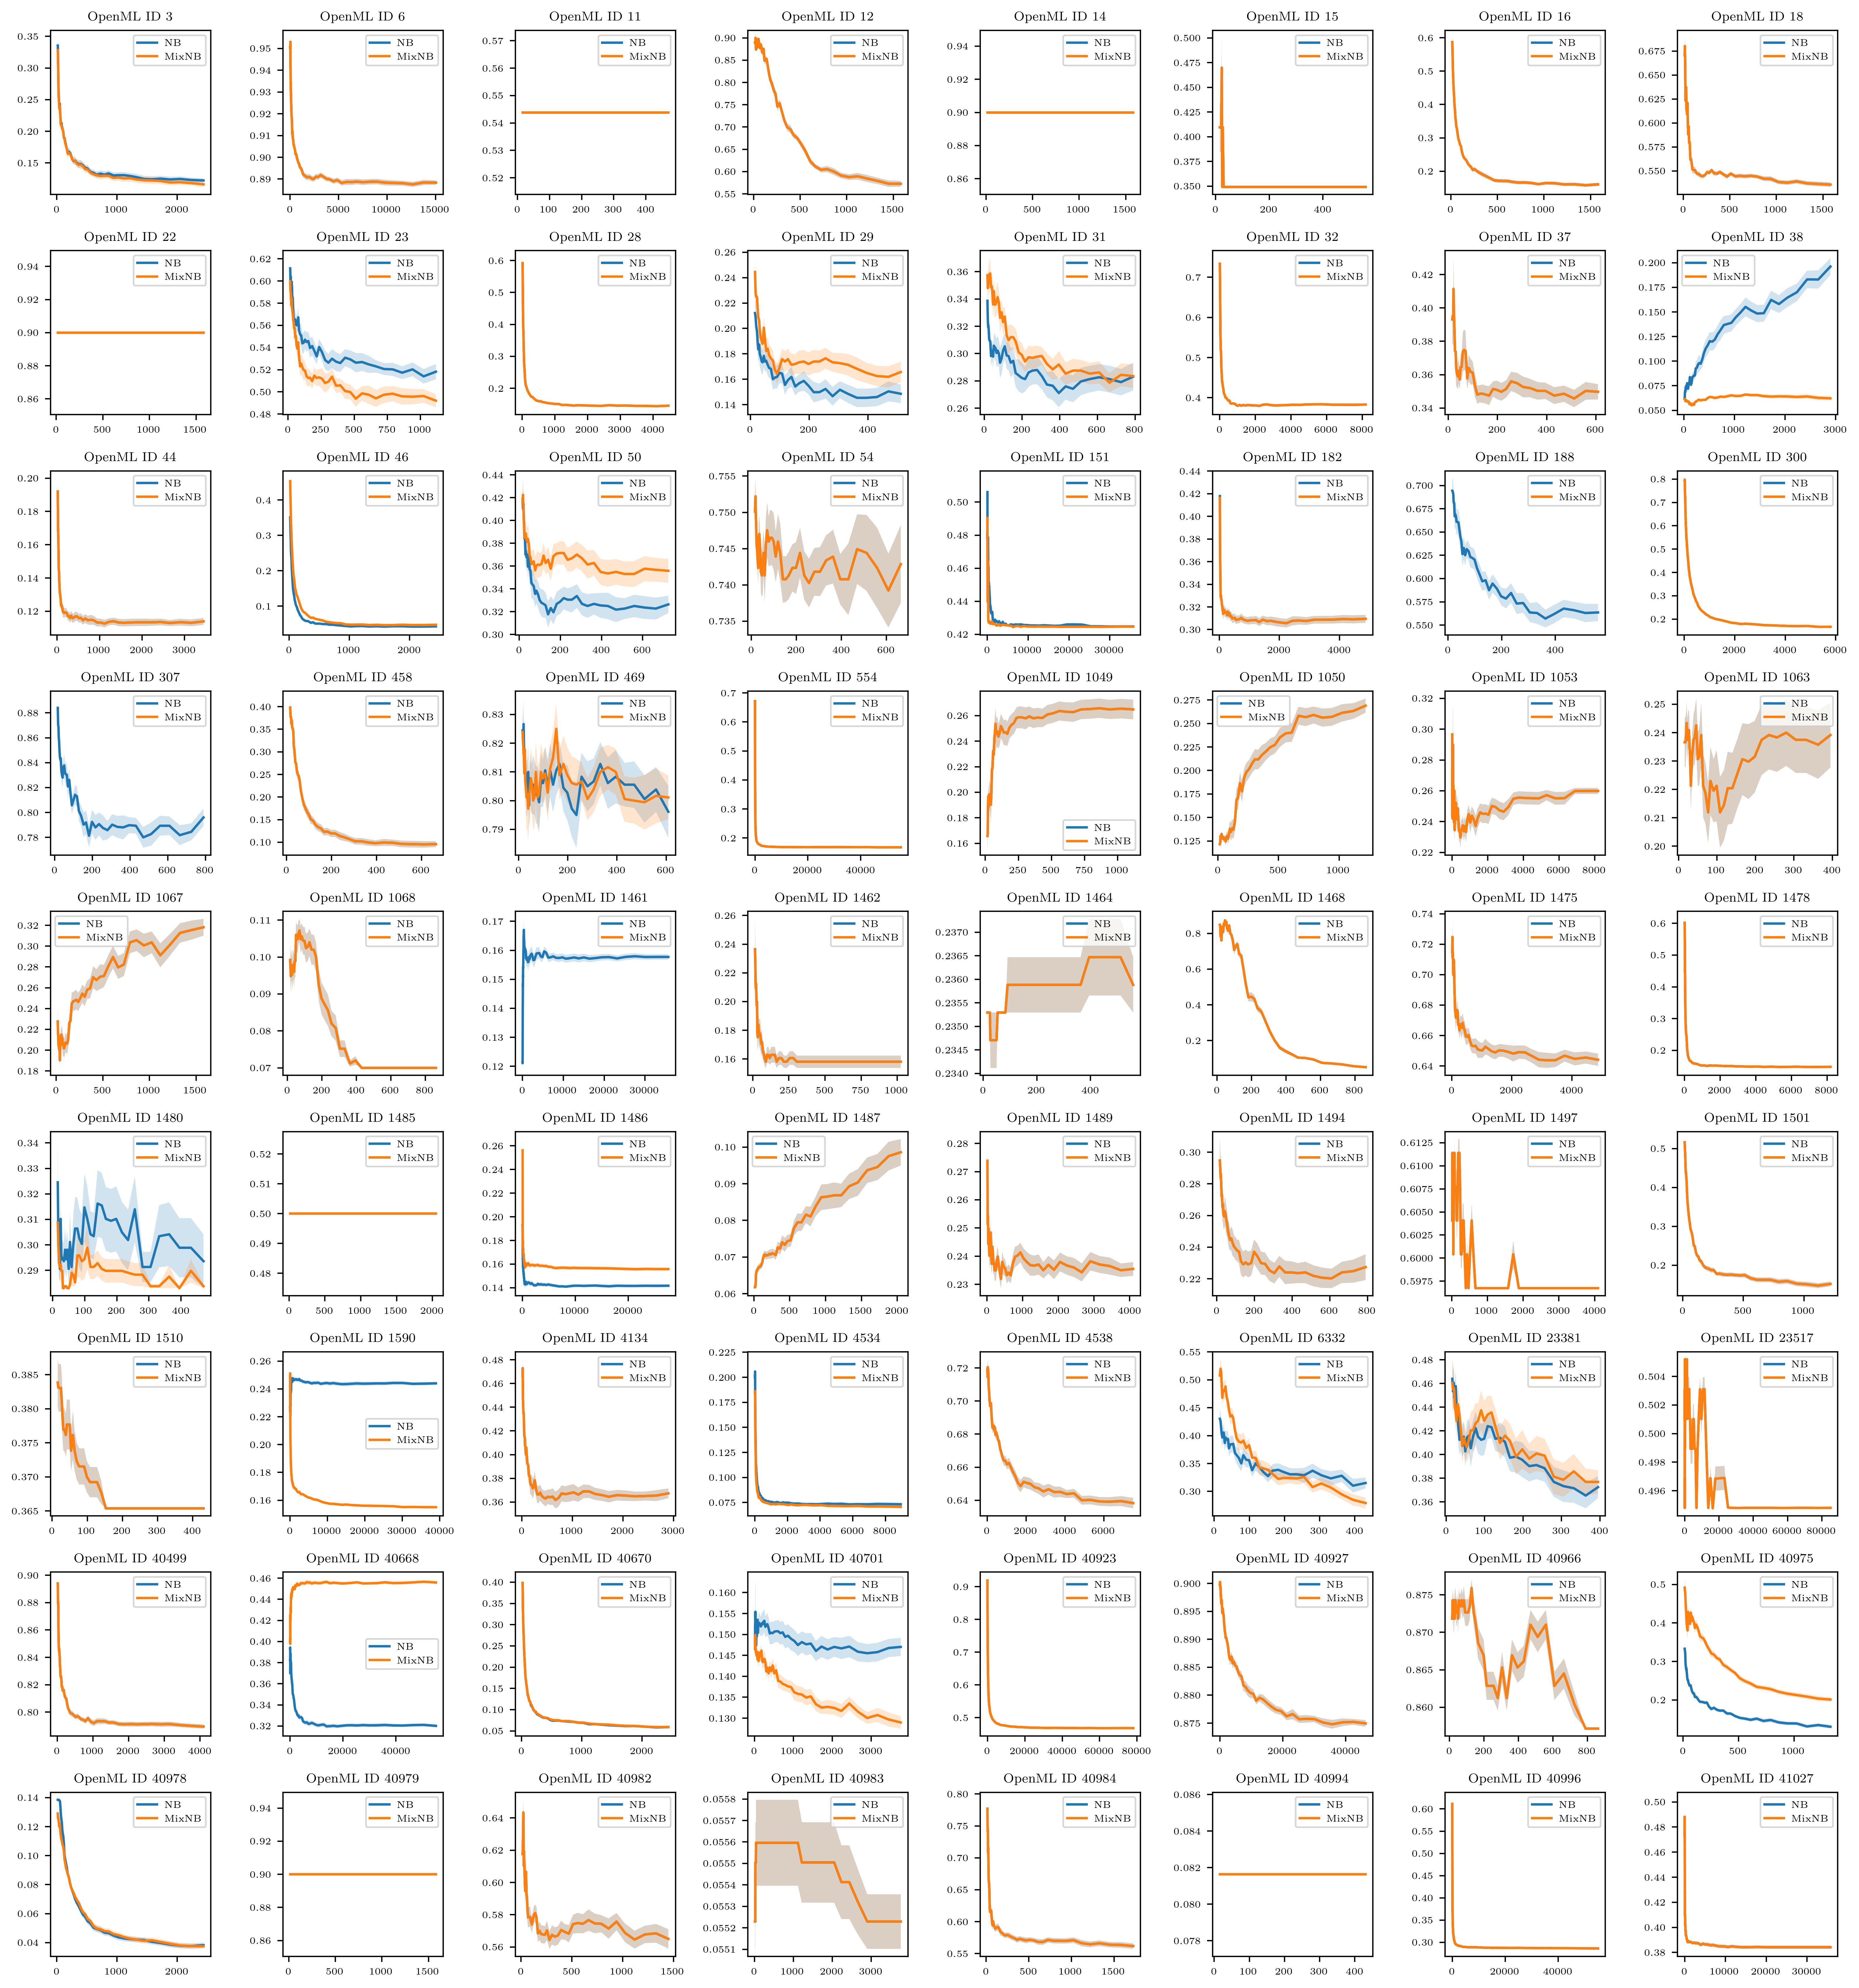

In [3]:
lc_clean_NB = dataset_nofs[:, 14:18, :, :, :, 1]
lc_clean_mixNB = dataset_nofs_mixNB[:, :, :, :, :, 1]

LEARNER = 0

fig, axes = plt.subplots(9, 8, figsize=(16, 18), dpi=400)

for data_id in range(72):
    row = data_id // 8
    col = data_id % 8
    ax = axes[row, col]
    # means and standard errors
    mean_clean_NB = np.nanmean(lc_clean_NB[data_id, LEARNER, :, :, :], axis=(0, 1))
    se_clean_NB = np.nanstd(lc_clean_NB[data_id, LEARNER, :, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean_NB[data_id, LEARNER, :, :, :]), axis=(0, 1)))
    mean_clean_mixNB = np.nanmean(lc_clean_mixNB[data_id, LEARNER, :, :, :], axis=(0, 1))
    se_clean_mixNB = np.nanstd(lc_clean_mixNB[data_id, LEARNER, :, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean_mixNB[data_id, LEARNER, :, :, :]), axis=(0, 1)))

    ax.plot(anchor_list_denser, mean_clean_NB, label="NB")
    ax.fill_between(anchor_list_denser, mean_clean_NB - se_clean_NB, mean_clean_NB + se_clean_NB, alpha=0.2)

    ax.plot(anchor_list_denser, mean_clean_mixNB, label="MixNB")
    ax.fill_between(anchor_list_denser, mean_clean_mixNB - se_clean_mixNB, mean_clean_mixNB + se_clean_mixNB, alpha=0.2)

    ax.set_title(f'OpenML ID {dataset_ids_CC18[data_id]}', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### average best performance

In [3]:
min_valid_noFS = np.nanmin(mean_valid_nofs, axis=2)
mean_min_valid_noFS = np.nanmean(min_valid_noFS, axis=0)

min_valid_minmaxFS = np.nanmin(mean_valid_minmaxfs, axis=2)
mean_min_valid_01FS = np.nanmean(min_valid_minmaxFS, axis=0)

min_valid_standardFS = np.nanmin(mean_valid_standardfs, axis=2)
mean_min_valid_standardFS = np.nanmean(min_valid_standardFS, axis=0)

C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\2921221778.py:1: RuntimeWarning: All-NaN slice encountered
  min_valid_noFS = np.nanmin(mean_valid_nofs, axis=2)
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\2921221778.py:7: RuntimeWarning: All-NaN slice encountered
  min_valid_standardFS = np.nanmin(mean_valid_standardfs, axis=2)
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\2921221778.py:8: RuntimeWarning: Mean of empty slice
  mean_min_valid_standardFS = np.nanmean(min_valid_standardFS, axis=0)


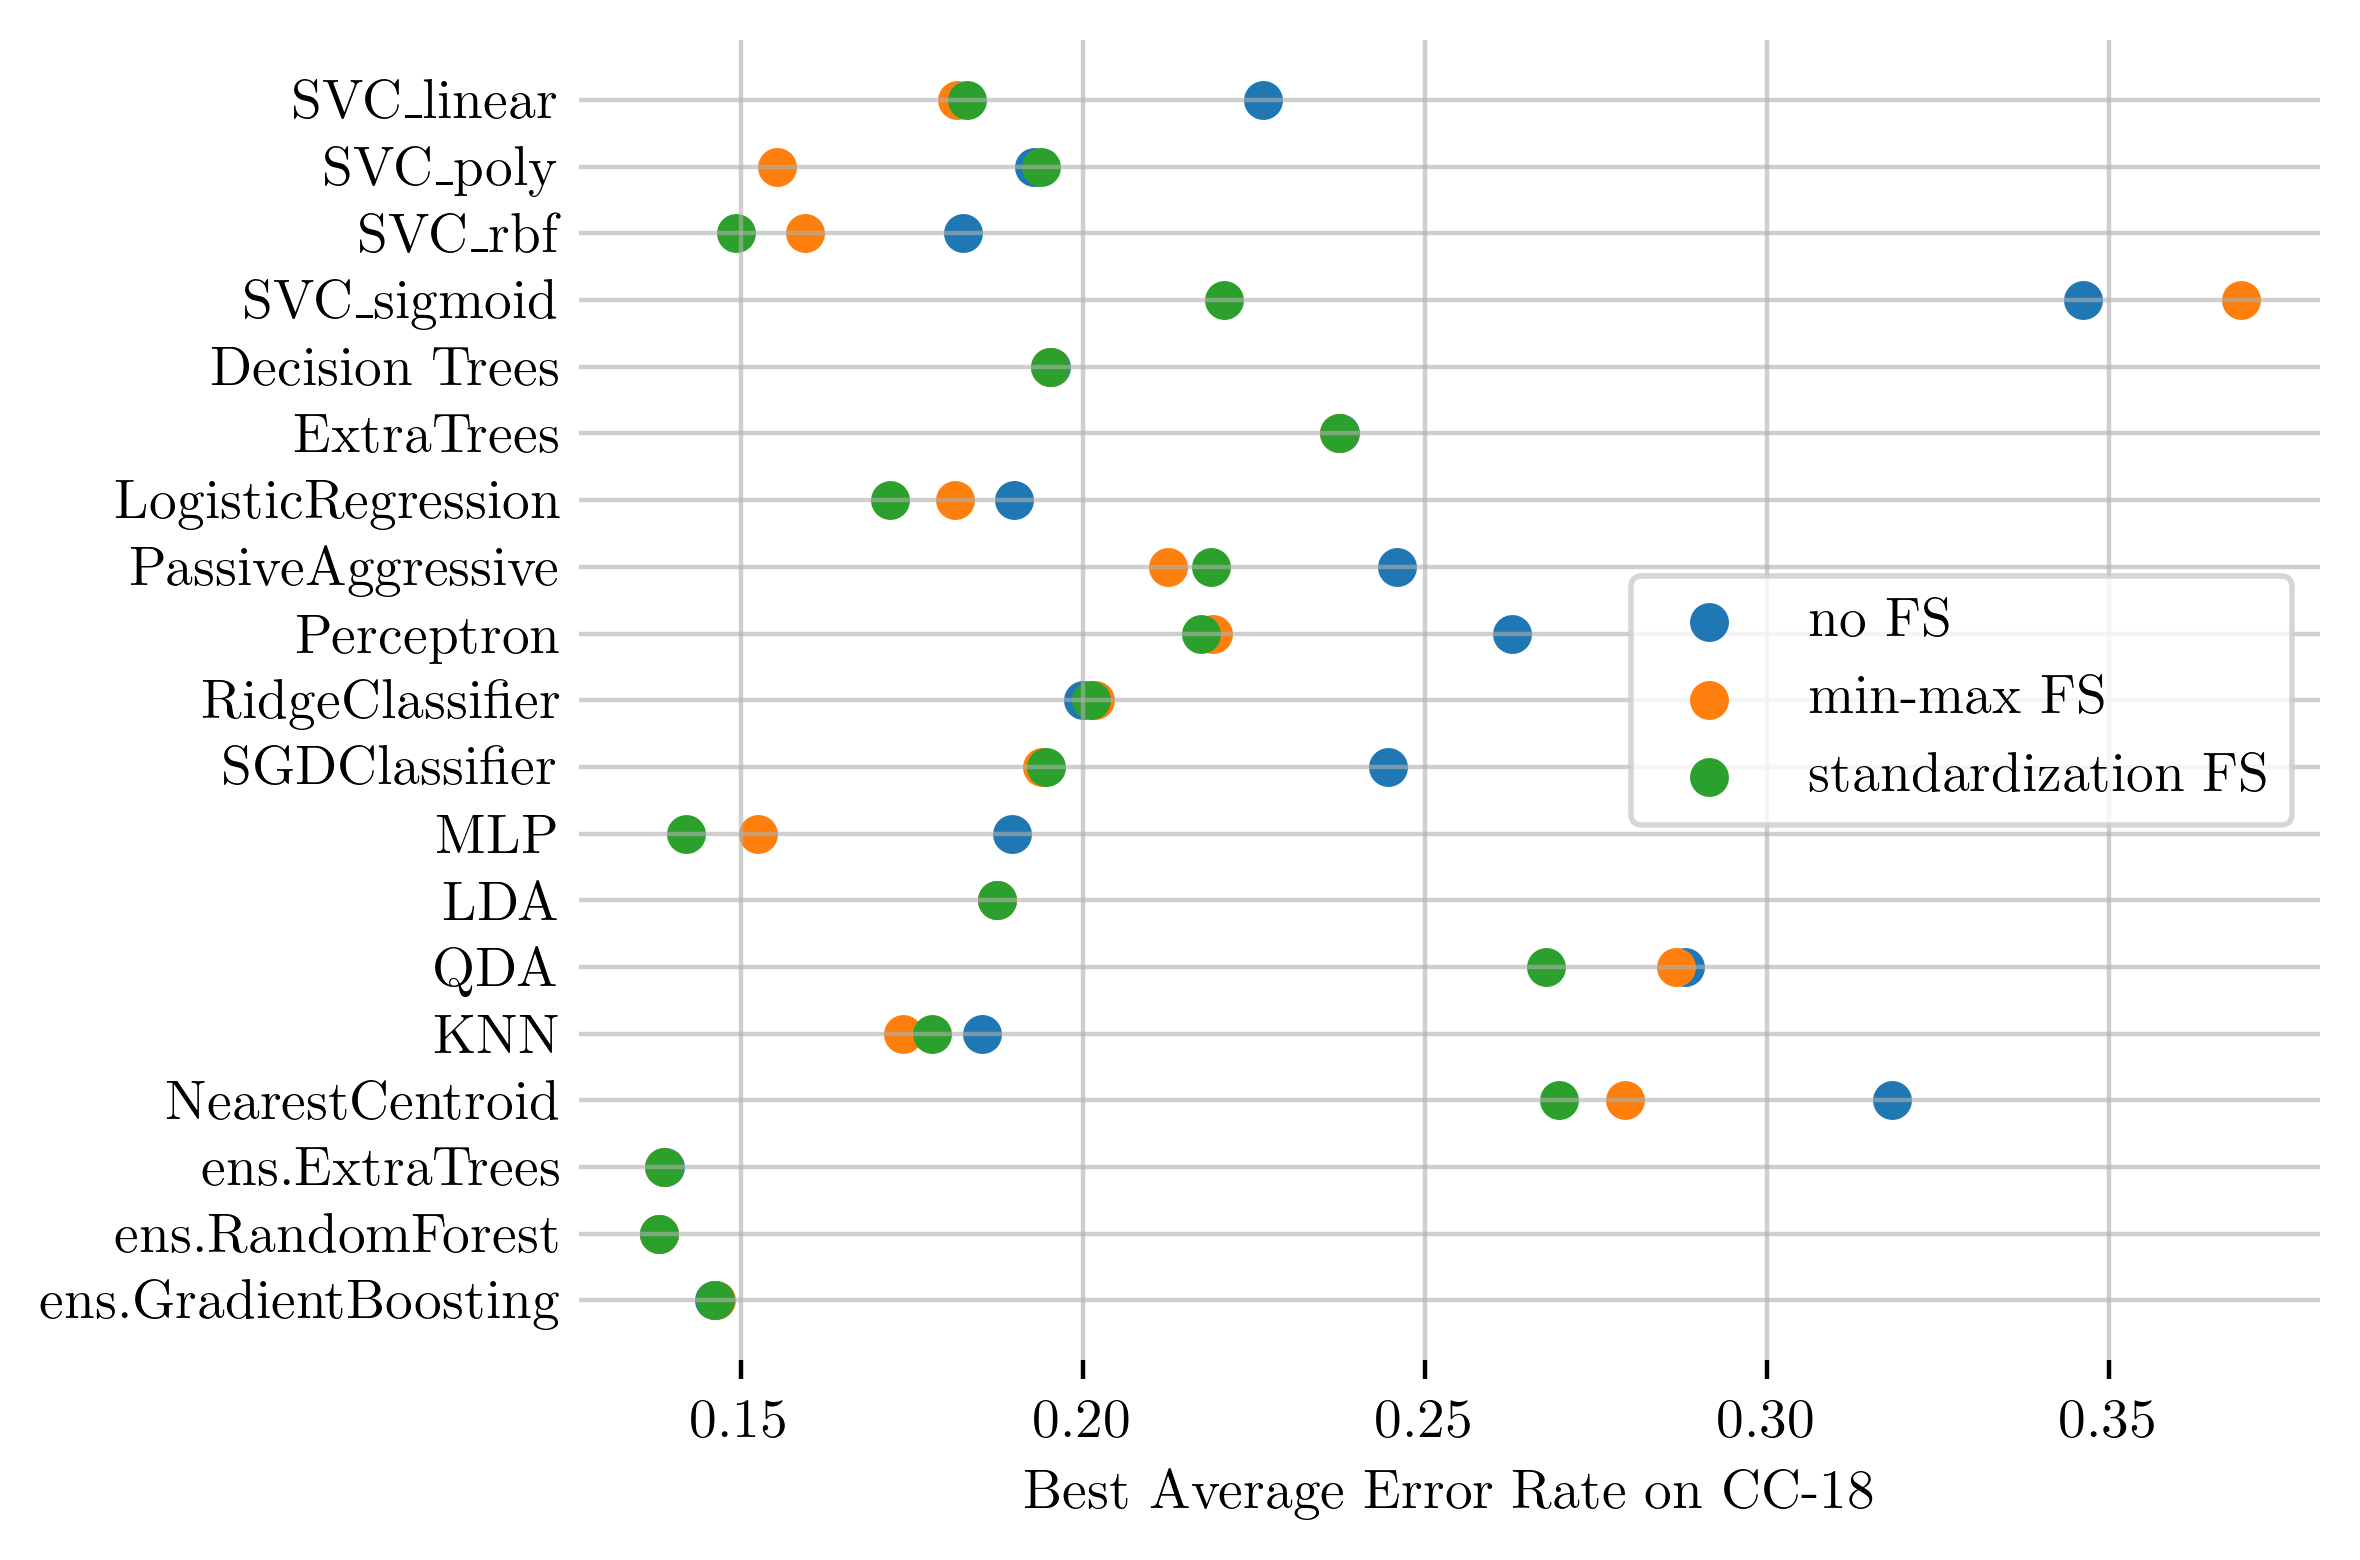

In [6]:
selected_learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22]

mean_min_valid_noFS_selected = [mean_min_valid_noFS[i] for i in selected_learners]
mean_min_valid_minmaxFS_selected = [mean_min_valid_01FS[i] for i in selected_learners]
mean_min_valid_standardFS_selected = [mean_min_valid_standardFS[i] for i in selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(6, 4), dpi=400)


plt.scatter(mean_min_valid_noFS_selected, x_pos, label='no FS')
plt.scatter(mean_min_valid_minmaxFS_selected, x_pos, label='min-max FS')
plt.scatter(mean_min_valid_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(x_pos, learner_zoo_selected)
plt.legend()
plt.xlabel("Best Average Error Rate on CC-18")
plt.tight_layout()
plt.show()


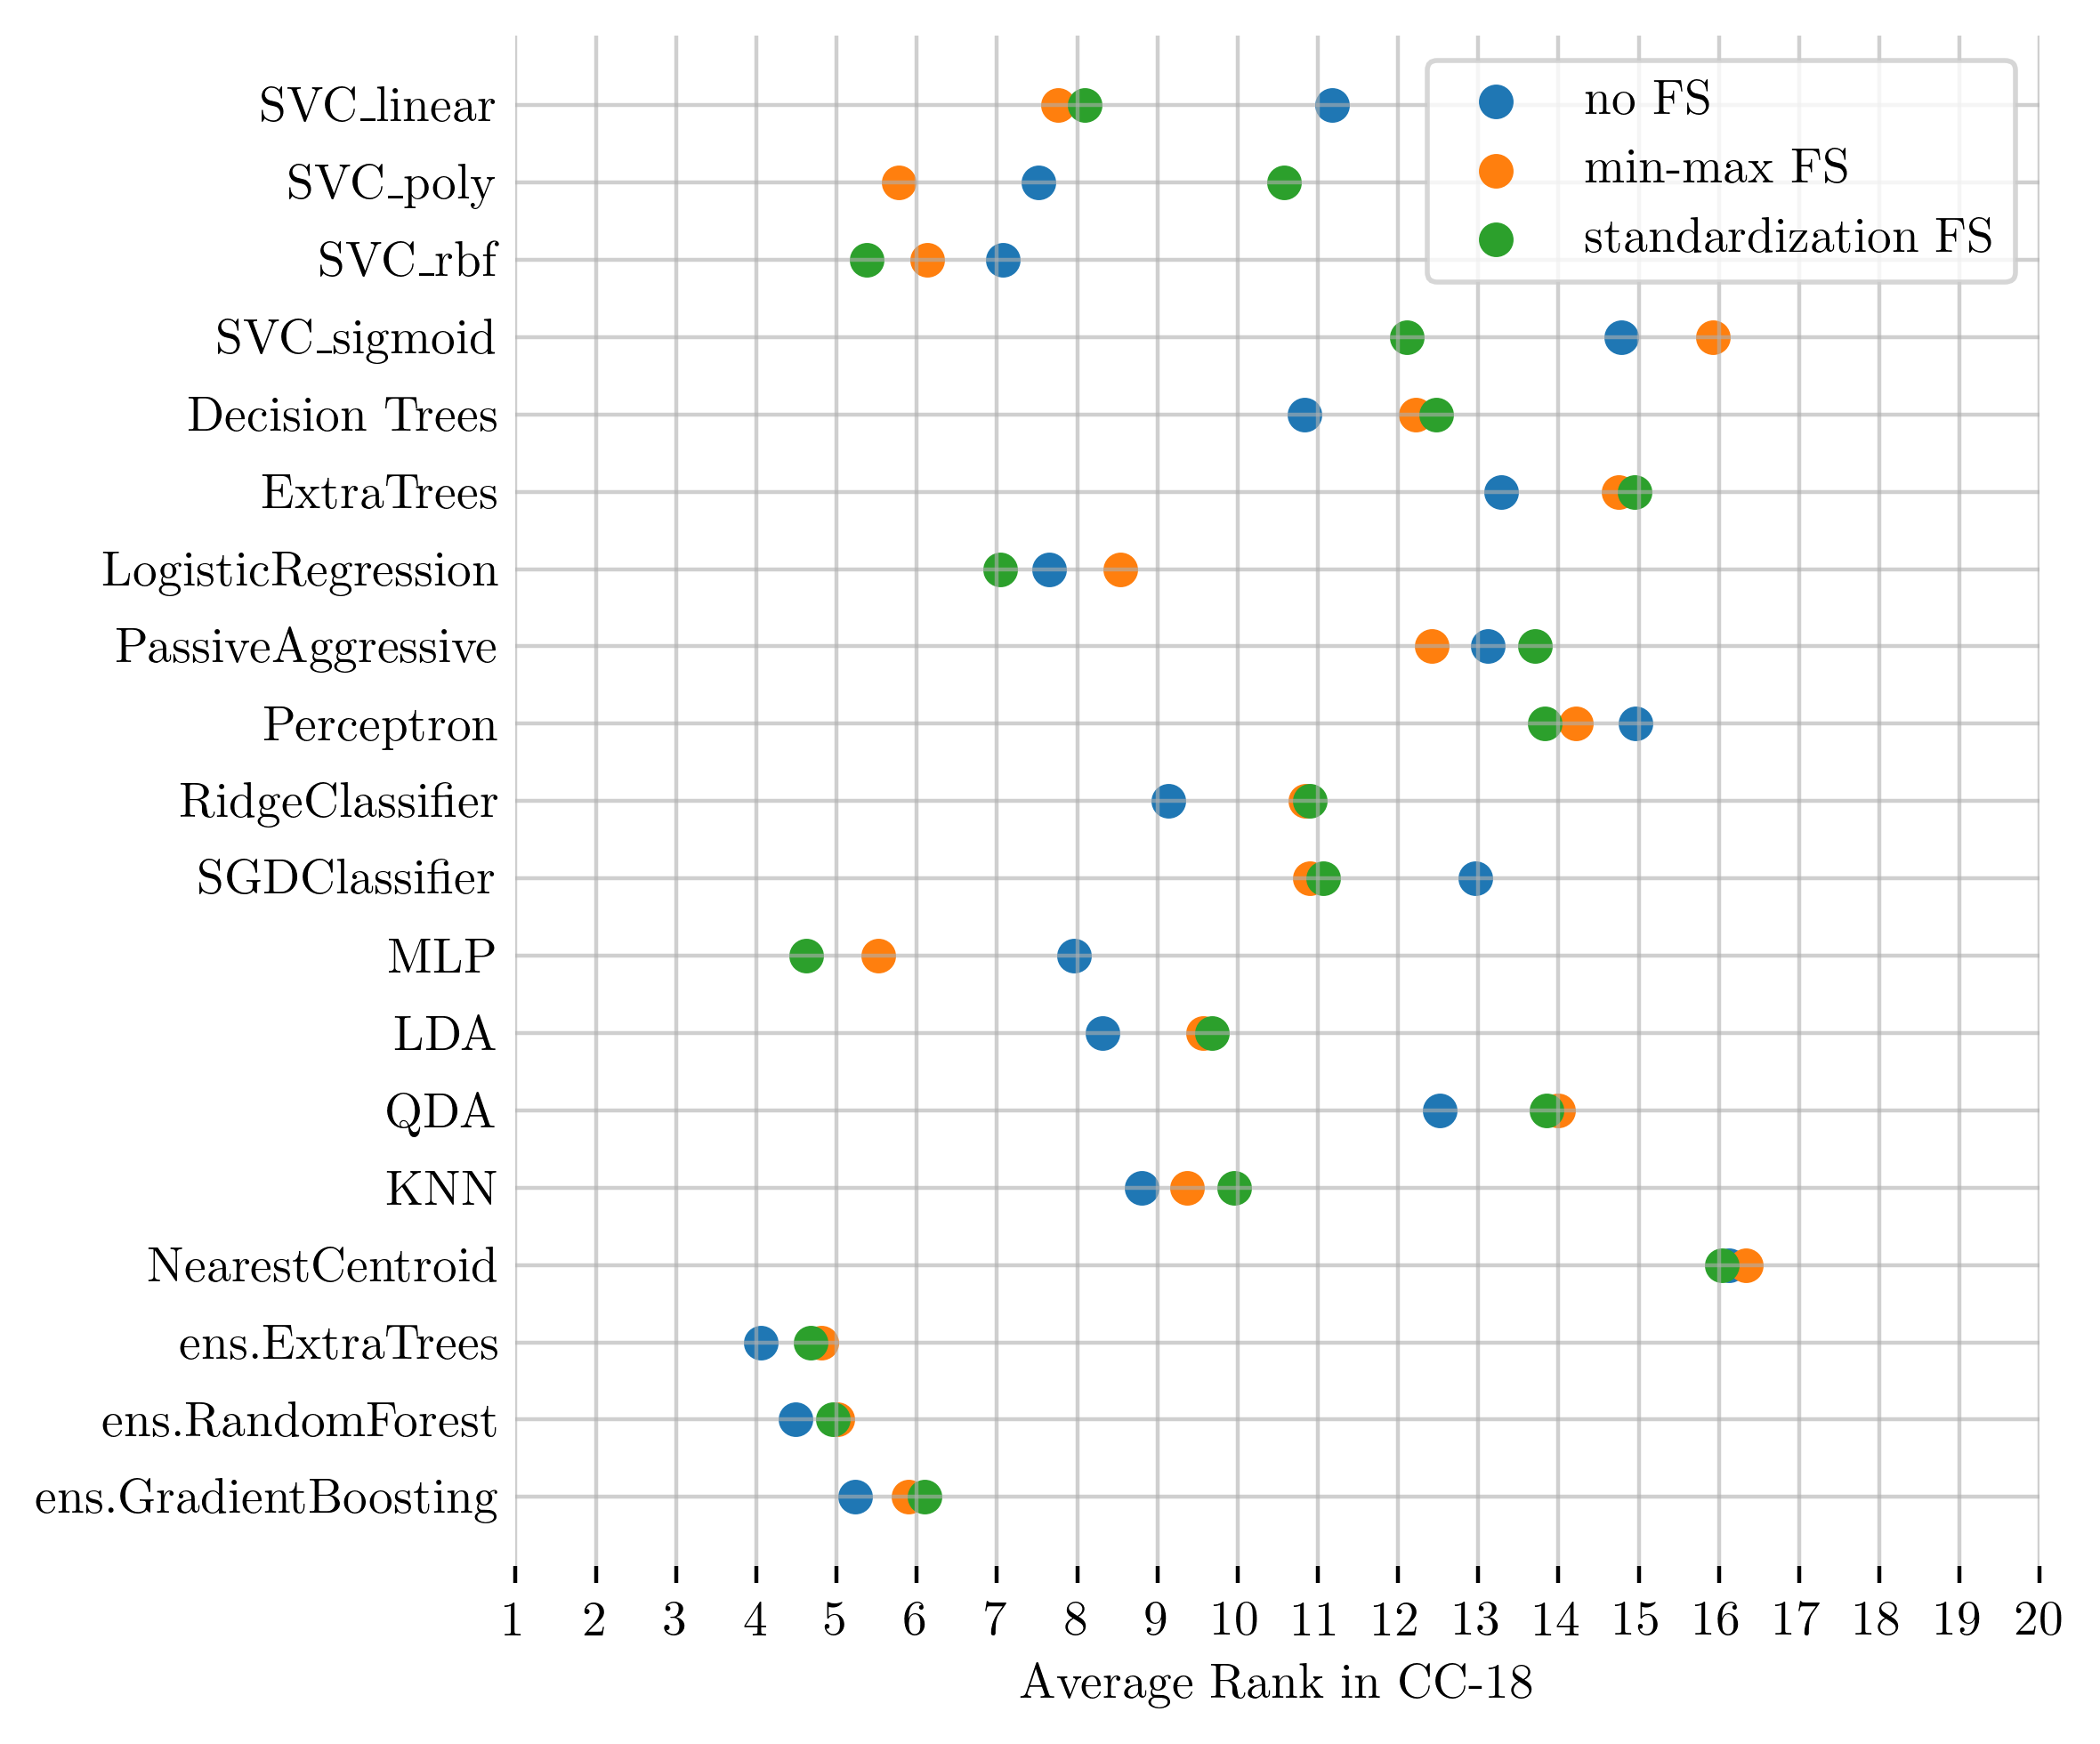

In [6]:
selected_learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22]
max_valid_noFS_selected = min_valid_noFS[:, selected_learners]
max_valid_01FS_selected = min_valid_minmaxFS[:, selected_learners]
max_valid_standardFS_selected = min_valid_standardFS[:, selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

rank_noFS_selected = np.nanmean(rankdata(max_valid_noFS_selected, axis=1), axis=0)
rank_01FS_selected = np.nanmean(rankdata(max_valid_01FS_selected, axis=1), axis=0)
rank_standardFS_selected = np.nanmean(rankdata(max_valid_standardFS_selected, axis=1), axis=0)


x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(6, 5), dpi=400)
plt.scatter(rank_noFS_selected, x_pos, label='no FS')
plt.scatter(rank_01FS_selected, x_pos, label='min-max FS')
plt.scatter(rank_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks(np.arange(1, 21, 1)) 
plt.yticks(x_pos, learner_zoo_selected)
# plt.xlim(0,19)
plt.legend()
plt.xlabel("Average Rank in CC-18")
plt.tight_layout()
plt.show()


mixNB

In [8]:
min_valid_noFS = np.nanmin(mean_valid_nofs, axis=2)
min_valid_noFS_NB = min_valid_noFS[:, 14:18]    #.shape  # [14, 15, 16, 17]
min_valid_noFS_mixNB = np.nanmin(mean_valid_nofs_mixNB, axis=2)

C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\3526311419.py:1: RuntimeWarning: All-NaN slice encountered
  min_valid_noFS = np.nanmin(mean_valid_nofs, axis=2)
C:\Users\cyan1\AppData\Local\Temp\ipykernel_19652\3526311419.py:3: RuntimeWarning: All-NaN slice encountered
  min_valid_noFS_mixNB = np.nanmin(mean_valid_nofs_mixNB, axis=2)


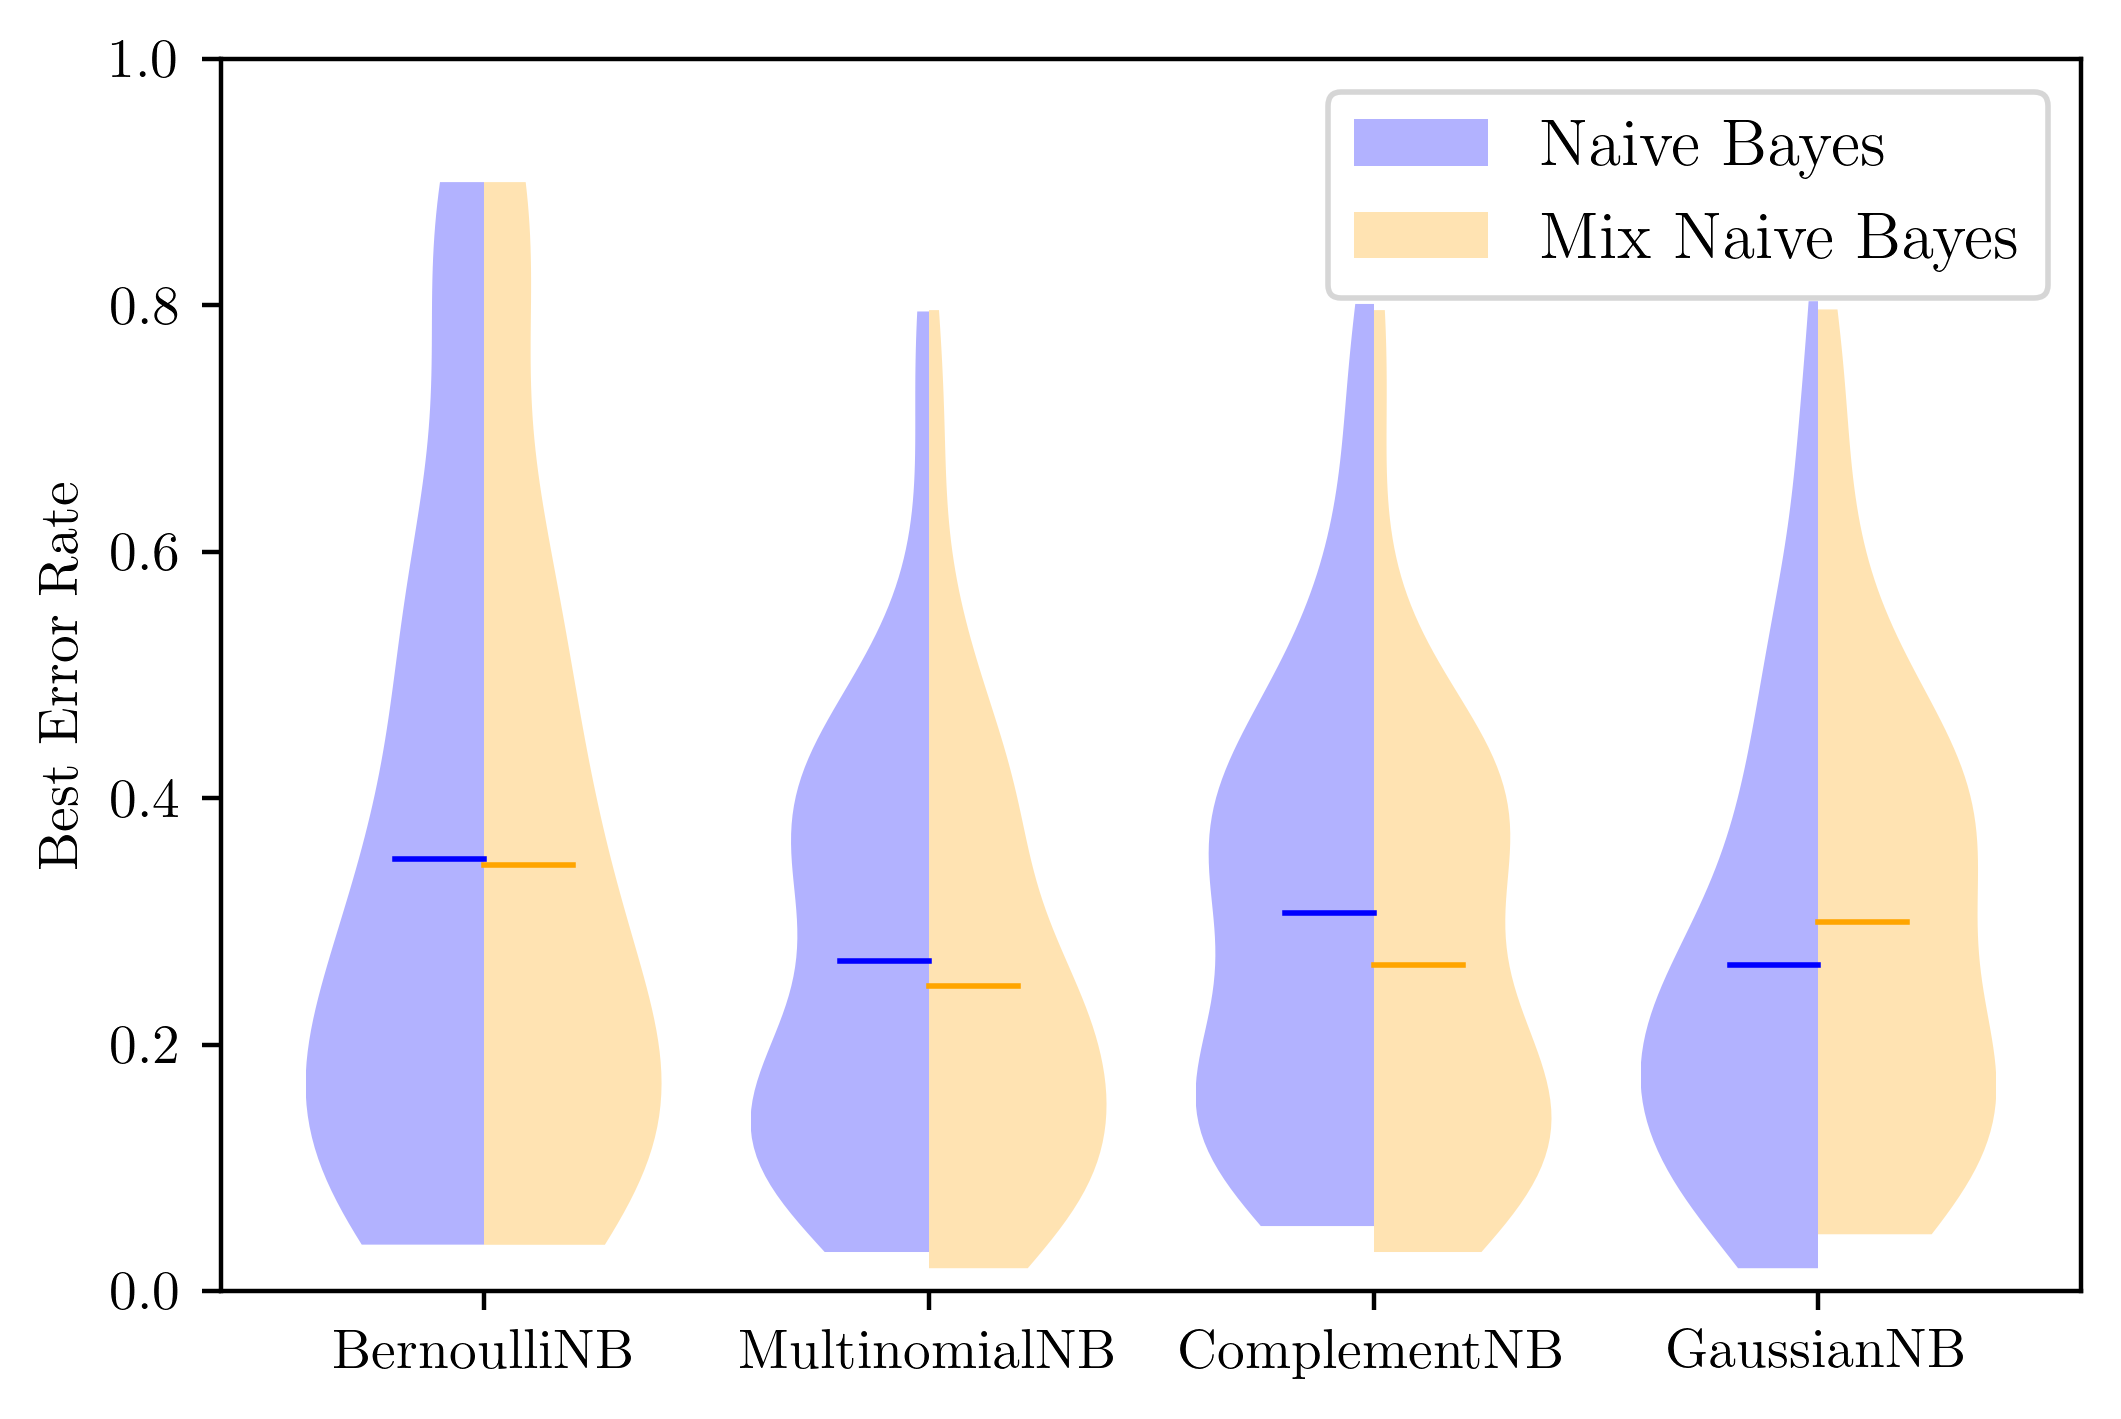

In [9]:
NB_learner = [14, 15, 16, 17]
model_names = [learner_zoo[i] for i in NB_learner]

df_NB = pd.DataFrame(min_valid_noFS_NB, columns=model_names)
df_NB['Type'] = 'NB'
df_mixNB = pd.DataFrame(min_valid_noFS_mixNB, columns=model_names)
df_mixNB['Type'] = 'mixNB'
df_combined = pd.concat([df_NB, df_mixNB])

# remove nan
df_melted = pd.melt(df_combined, id_vars='Type', var_name='Model', value_name='Value')
df_melted = df_melted.dropna(subset=['Value'])

plt.figure(figsize=(6, 4), dpi=400)
positions = np.arange(len(model_names))

for i, model in enumerate(model_names):
    data_NB = df_melted[(df_melted['Model'] == model) & (df_melted['Type'] == 'NB')]['Value'].dropna()
    data_mixNB = df_melted[(df_melted['Model'] == model) & (df_melted['Type'] == 'mixNB')]['Value'].dropna()

    # Violin NB
    vp_NB = plt.violinplot(data_NB, positions=[i], widths=0.8, showextrema=False)
    for b in vp_NB['bodies']:
        b.set_facecolor('blue')
        b.set_clip_path(plt.Rectangle((i - 0.4, 0), 0.4, 1, transform=plt.gca().transData))

    # Violin mixNB
    vp_mixNB = plt.violinplot(data_mixNB, positions=[i], widths=0.8, showextrema=False)
    for b in vp_mixNB['bodies']:
        b.set_facecolor('orange')
        b.set_clip_path(plt.Rectangle((i, 0), 0.4, 1, transform=plt.gca().transData))

    # mean NB
    mean_NB = np.mean(data_NB)
    plt.plot([i - 0.2, i], [mean_NB, mean_NB], color='blue', linewidth=1)

    # # extrema NB
    # min_NB = np.min(data_NB)
    # max_NB = np.max(data_NB)
    # plt.plot([i - 0.2, i], [min_NB, min_NB], color='blue', linewidth=1)
    # plt.plot([i - 0.2, i], [max_NB, max_NB], color='blue', linewidth=1)

    # mean mixNB
    mean_mixNB = np.mean(data_mixNB)
    plt.plot([i, i + 0.2], [mean_mixNB, mean_mixNB], color='orange', linewidth=1)

    # # extrema mixNB
    # min_mixNB = np.min(data_mixNB)
    # max_mixNB = np.max(data_mixNB)
    # plt.plot([i, i + 0.2], [min_mixNB, min_mixNB], color='orange', linewidth=1)
    # plt.plot([i, i + 0.2], [max_mixNB, max_mixNB], color='orange', linewidth=1)

plt.xticks(positions, model_names)
plt.ylabel('Best Error Rate')
plt.legend([vp_NB['bodies'][0], vp_mixNB['bodies'][0]], ['Naive Bayes', 'Mix Naive Bayes'], fontsize=12)
plt.ylim(0, 1) 
plt.show()


SVM

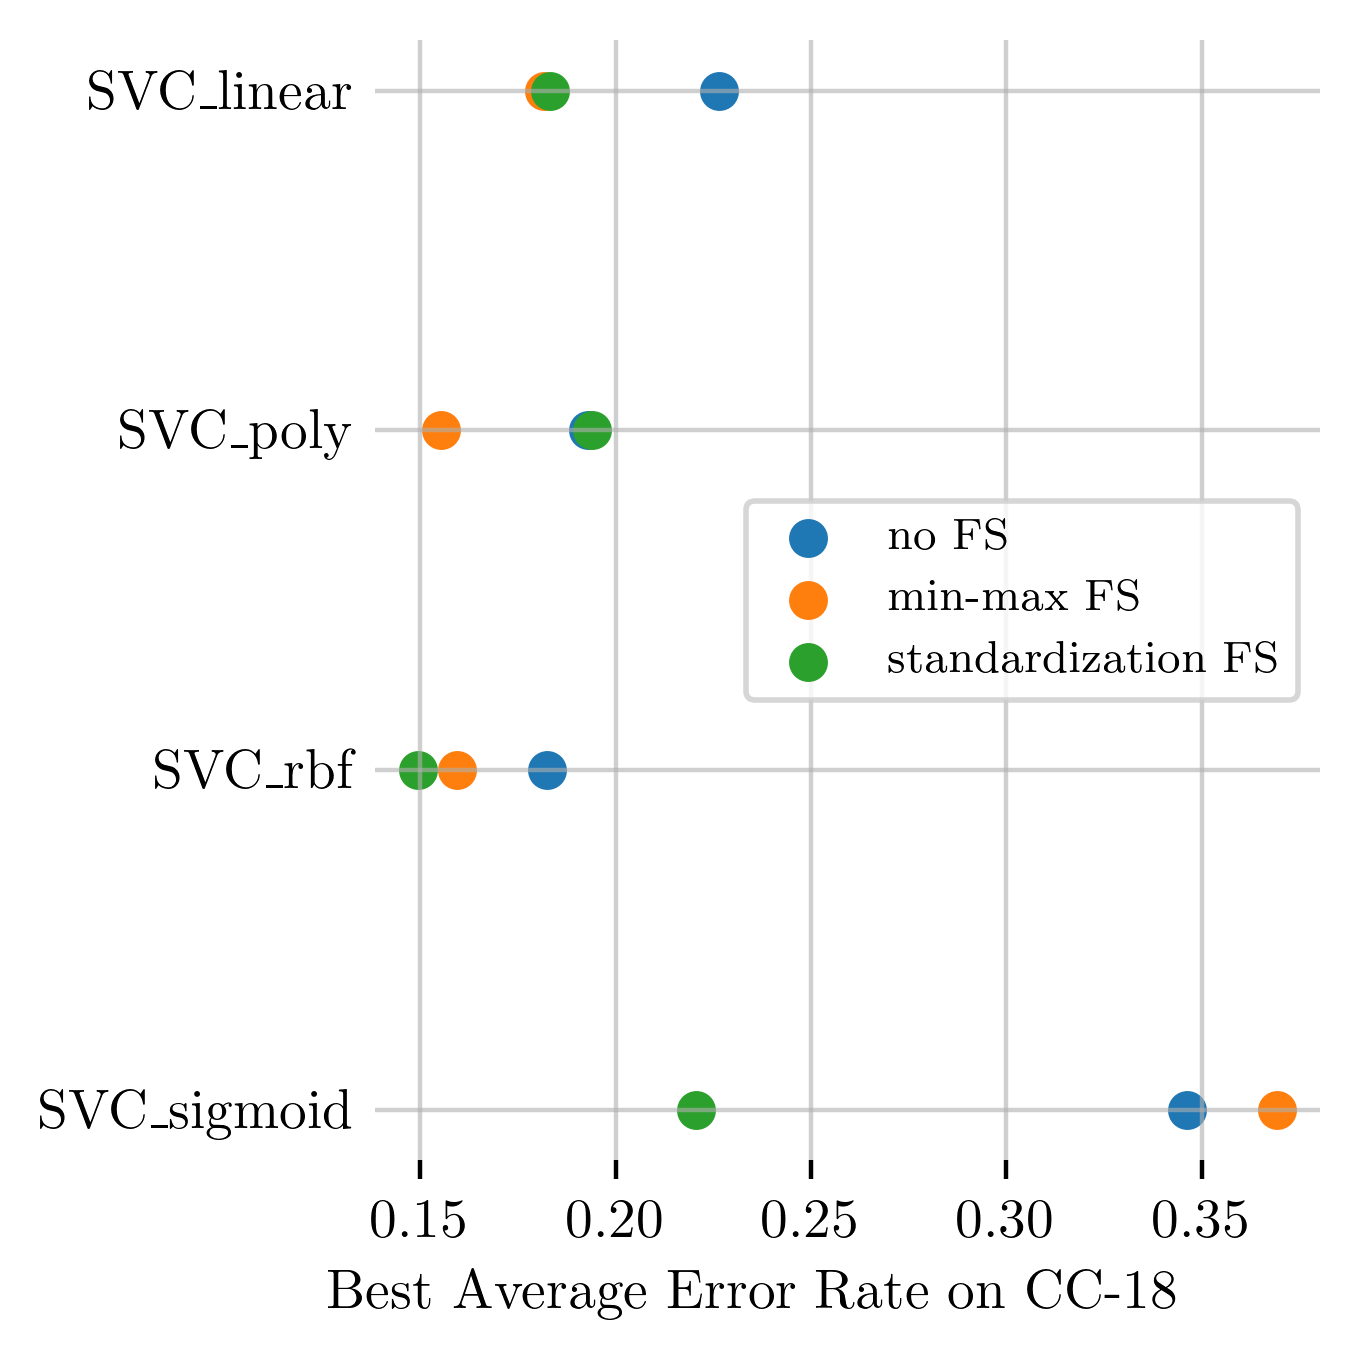

In [10]:
selected_learners = [0, 1, 2, 3]

mean_min_valid_noFS_selected = [mean_min_valid_noFS[i] for i in selected_learners]
mean_min_valid_minmaxFS_selected = [mean_min_valid_01FS[i] for i in selected_learners]
mean_min_valid_standardFS_selected = [mean_min_valid_standardFS[i] for i in selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(3.5, 3.5), dpi=400)


plt.scatter(mean_min_valid_noFS_selected, x_pos, label='no FS')
plt.scatter(mean_min_valid_minmaxFS_selected, x_pos, label='min-max FS')
plt.scatter(mean_min_valid_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(x_pos, learner_zoo_selected)
plt.legend(loc='center right', fontsize = 8)
plt.xlabel("Best Average Error Rate on CC-18", x=0.4)
# plt.title("Average Minimum Error Rate over CC18 (Selected Learners)")
plt.tight_layout()
plt.show()


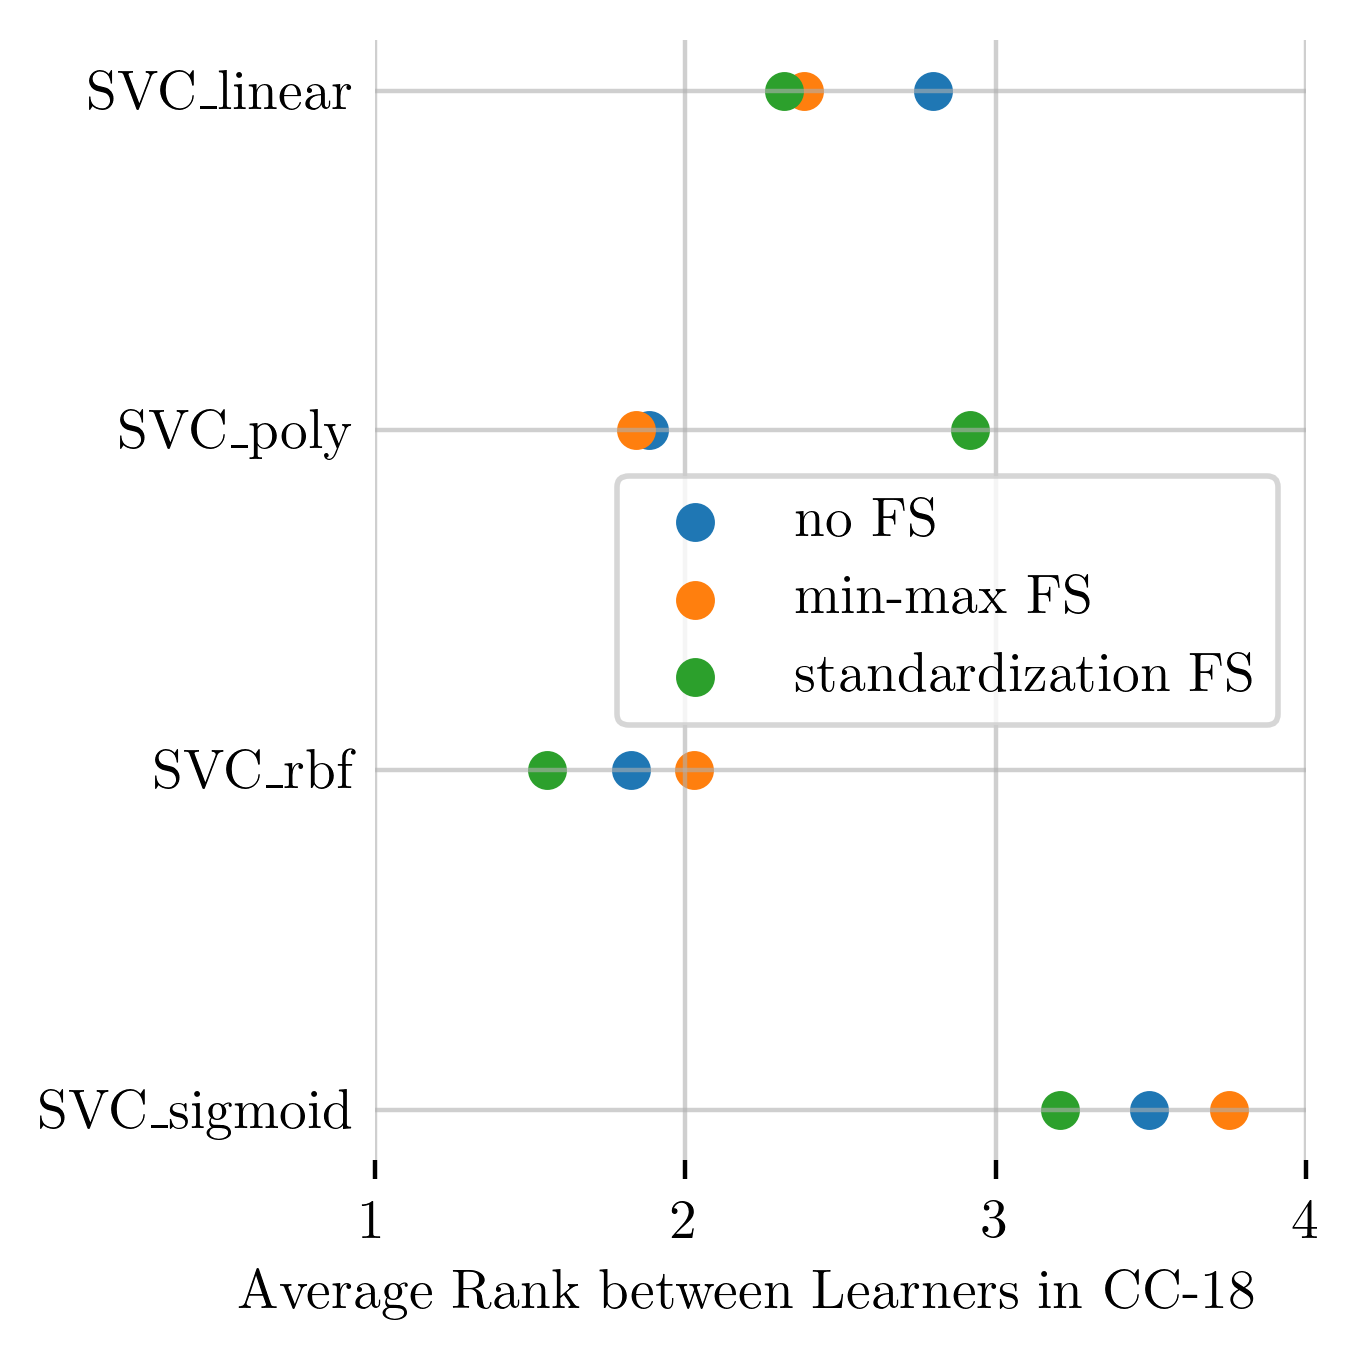

In [10]:
selected_learners = [0, 1, 2, 3]
max_valid_noFS_selected = min_valid_noFS[:, selected_learners]
max_valid_01FS_selected = min_valid_minmaxFS[:, selected_learners]
max_valid_standardFS_selected = min_valid_standardFS[:, selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

rank_noFS_selected = np.nanmean(rankdata(max_valid_noFS_selected, axis=1), axis=0)
rank_01FS_selected = np.nanmean(rankdata(max_valid_01FS_selected, axis=1), axis=0)
rank_standardFS_selected = np.nanmean(rankdata(max_valid_standardFS_selected, axis=1), axis=0)


x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(3.5, 3.5), dpi=400)
plt.scatter(rank_noFS_selected, x_pos, label='no FS')
plt.scatter(rank_01FS_selected, x_pos, label='min-max FS')
plt.scatter(rank_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks(np.arange(1, 5, 1)) 
plt.yticks(x_pos, learner_zoo_selected)
# plt.xlim(0,19)
plt.legend()
plt.xlabel("Average Rank between Learners in CC-18", x=0.4)
plt.tight_layout()
plt.show()


In [11]:
selected_learners = [0, 1, 2, 3]
max_valid_noFS_selected = min_valid_noFS[:, selected_learners]
max_valid_01FS_selected = min_valid_minmaxFS[:, selected_learners]
max_valid_standardFS_selected = min_valid_standardFS[:, selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

performance_stack = np.stack([
                max_valid_noFS_selected, 
                max_valid_01FS_selected, 
                max_valid_standardFS_selected], axis=2)  # shape: (dataset, learner, FS)

# average over all datasets
fs_rank_per_learner = np.nanmean(rankdata(performance_stack, axis=2), axis=0)


fs_labels = ["no FS", "min-max FS", "standardization FS"]
for i, learner in enumerate(learner_zoo_selected):
    print(f"{learner}:")
    for fs, rank in zip(fs_labels, fs_rank_per_learner[i]):
        print(f"  {fs}: average ranking = {rank:.3f}")
    print()

SVC_linear:
  no FS: average ranking = 2.479
  min-max FS: average ranking = 1.778
  standardization FS: average ranking = 1.743

SVC_poly:
  no FS: average ranking = 2.118
  min-max FS: average ranking = 1.479
  standardization FS: average ranking = 2.403

SVC_rbf:
  no FS: average ranking = 2.333
  min-max FS: average ranking = 2.007
  standardization FS: average ranking = 1.660

SVC_sigmoid:
  no FS: average ranking = 2.410
  min-max FS: average ranking = 2.292
  standardization FS: average ranking = 1.299

